In [11]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import scipy
import anndata as ad
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [2]:
atac_genescore = sc.read('/omics/groups/OE0540/internal/users/msaraswat/GBM_25_05/genescore_metacell_scdori_11_03_24.h5ad')
sc.pp.normalize_total(atac_genescore)

rna = sc.read('/omics/groups/OE0540/internal/users/msaraswat/GBM_25_05/rna_metacell_scdori_11_03_24.h5ad')
sc.pp.normalize_total(rna)

sc.pp.log1p(rna)

common_genes = list(set(rna.var.index.values).intersection(set(atac_genescore.var.index.values)))

rna = rna[:,common_genes].copy()
atac_genescore = atac_genescore[:,common_genes].copy()

rna.obs['annotation'] = [s.split('|')[1] for s in rna.obs.index.values]
rna.obs['batch'] = [s.split('|')[2] for s in rna.obs.index.values]
rna.obs['donor'] = [s.split('|')[3] for s in rna.obs.index.values]
rna.obs['index_new'] = rna.obs.index.values


atac_genescore.obs['annotation'] = [s.split('|')[1] for s in atac_genescore.obs.index.values]
atac_genescore.obs['batch'] = [s.split('|')[2] for s in atac_genescore.obs.index.values]
atac_genescore.obs['donor'] = [s.split('|')[3] for s in atac_genescore.obs.index.values]
atac_genescore.obs['index_new'] = atac_genescore.obs.index.values

In [3]:
rna = rna[~(rna.obs.annotation.isin(['Undefined'])),:]
atac_genescore = atac_genescore[rna.obs.index.values].copy()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import numpy as np


In [ ]:
# Assuming 'df' is your DataFrame and it includes columns like 'Gene1', 'Gene2', ..., 'GeneN', 'Batch', 'CellType'
df = rna.obs.copy()
# Encoding categorical data
label_encoder = LabelEncoder()
df['CellType'] = label_encoder.fit_transform(df['annotation'])
batch_encoded = pd.get_dummies(df['batch'], prefix='batch')

# Features and target
X_genes =rna.X  # gene expressions

X = pd.DataFrame(X_genes, index=batch_encoded.index.values)

y = df['CellType']

# Splitting the data ensuring batches are in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['batch'])


# balacning class weight

pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000,multi_class='multinomial',class_weight='balanced'))

# for upsampling
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# pipeline.fit(X_train_res, y_train_res)


pipeline.fit(X_train, y_train)


In [ ]:
log_reg = pipeline.named_steps['logisticregression']

In [15]:
# test cells

y_pred = pipeline.predict(X_test)


# Evaluating
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(cm)

Accuracy: 0.9525114155251142
Confusion Matrix:
[[196   5   0   0   1   0   0   2   0   0   1   3   0   0   0   1   0]
 [  8 298   2   0   0   0   0   1   0   0   1   3   2   0   0   3   0]
 [  1   2  63   0   0   0   1   0   0   0   0   1   0   1   1   0   0]
 [  3   1   0 127   5   0   0   0   0   0   0   1   0   0   0   0   0]
 [  2   0   0   1 235   0   0   0   0   0   1   1   0   0   1   0   0]
 [  2   0   0   0   0  83   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 366   0   0   0   0   0   0   0   0   0   0]
 [  1   1   0   0   0   0   1 207   1   0   3   8   0   2   1   0   0]
 [  0   1   0   0   0   0   0   1 165   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   2 128   0   0   0   0   0   0   0]
 [  1   1   0   0   0   0   0   0   0   0 164   6   2   0   0   1   0]
 [  8   3   0   3   0   0   1   4   0   0   9 255   1   0   0   0   1]
 [  2   1   0   0   0   0   0   4   0   0   1   2  84   0   0   0   0]
 [  0   0   0   0   0   0   0 

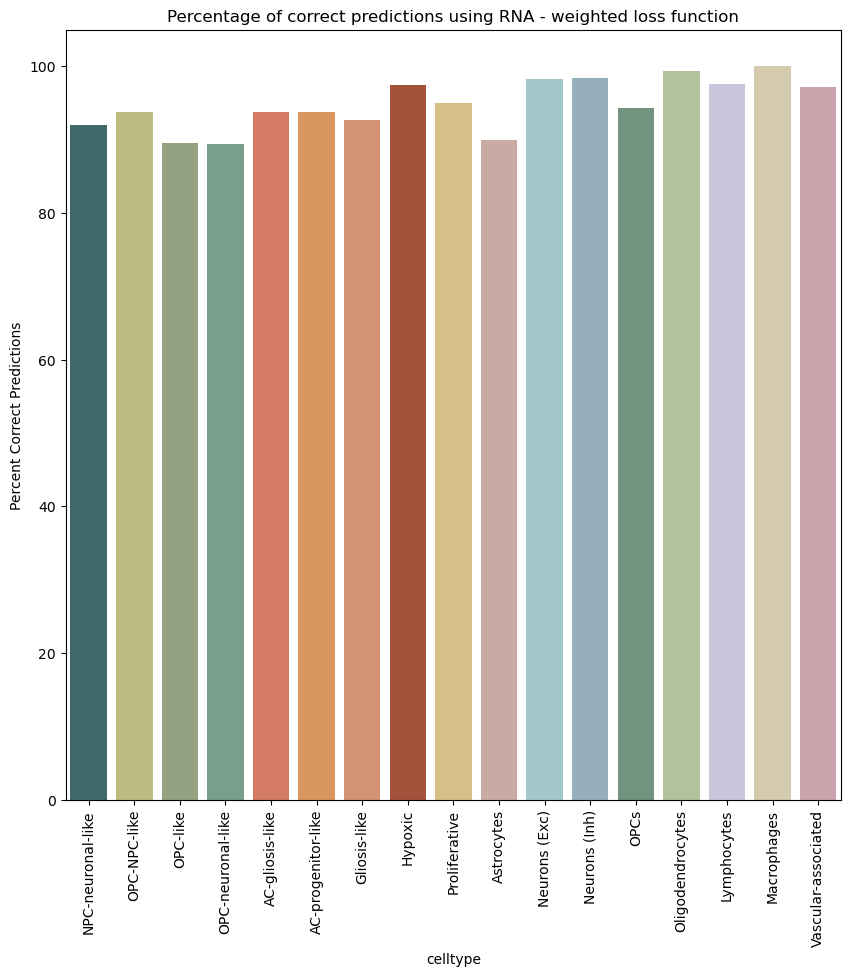

In [16]:
total_samples_per_class = cm.sum(axis=1)
correct_predictions = np.diag(cm)
percent_correct = (correct_predictions / total_samples_per_class) * 100
s = df['CellType'].drop_duplicates()
s = pd.DataFrame(s)
s['celltype'] = [k.split('|')[1] for k in s.index.values]
s  =s.sort_values(by='CellType')
s['Percent Correct Predictions'] = percent_correct
s = s.drop(columns = 'CellType')

celltype_order= ['NPC-neuronal-like','OPC-NPC-like', 'OPC-like', 'OPC-neuronal-like','AC-gliosis-like', 'AC-progenitor-like','Gliosis-like', 'Hypoxic', 'Proliferative','Astrocytes','Neurons (Exc)', 'Neurons (Inh)', 'OPCs',
       'Oligodendrocytes', 'Lymphocytes', 'Macrophages','Vascular-associated']




# sns.set_style("whitegrid")
# plt.figure(figsize=(15, 8))
cmap_celltype = {'NPC-neuronal-like': '#3B6F71',
'OPC-neuronal-like': '#70A68B',
'OPC-NPC-like':  '#C5C675',
'OPC-like': '#96A87B',
'Proliferative': '#E3C67B',
'AC-progenitor-like': '#EE9648',
'AC-gliosis-like': '#E57051',
'Gliosis-like': '#E28D63',
'Hypoxic': '#B7482A',
'Astrocytes': '#D0A79D',
'OPCs': '#6D997F',
'Oligodendrocytes': '#B0C996',
'Neurons (Exc)': '#9DCDD0',
'Neurons (Inh)': '#90B3C1',
'Macrophages': '#DBCDA7',
'Lymphocytes': '#C6C2E0',
'Vascular-associated': '#D09DA8',
'Undefined': '#DCDCDC',
'NA': '#C3C3C3'}


plt.figure(figsize=(10, 10))
ax = sns.barplot(data=s, x='celltype', y='Percent Correct Predictions', order=celltype_order, palette=cmap_celltype)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('Percentage of correct predictions using RNA - weighted loss function') 

plt.show()

plt.close()

In [17]:
y_pred_rna = pipeline.predict(X)
y_prob_rna = pipeline.predict_proba(X)
#X_test = scaler.transform(X_test)
#y_pred = model.predict(X_test)

# Evaluating
accuracy = accuracy_score(y, y_pred_rna)
cm = confusion_matrix(y, y_pred_rna)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(cm)

Accuracy: 0.9905011264689765
Confusion Matrix:
[[ 924    5    0    0    1    0    0    2    0    0    1    3    0    0
     0    1    0]
 [   8 1487    2    0    0    0    0    1    0    0    1    3    2    0
     0    3    0]
 [   1    2  332    0    0    0    1    0    0    0    0    1    0    1
     1    0    0]
 [   3    1    0  603    5    0    0    0    0    0    0    1    0    0
     0    0    0]
 [   2    0    0    1 1185    0    0    0    0    0    1    1    0    0
     1    0    0]
 [   2    0    0    0    0  437    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0 1743    0    0    0    0    0    0    0
     0    0    0]
 [   1    1    0    0    0    0    1 1092    1    0    3    8    0    2
     1    0    0]
 [   0    1    0    0    0    0    0    1  881    1    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    2  743    0    0    0    0
     0    0    0]
 [   1    1    0    0    0    0    0    0    0    0  

In [18]:
# for ATAC
df_atac = atac_genescore.obs.copy()
# Encoding categorical data

df_atac['CellType'] = label_encoder.transform(df_atac['annotation'])
batch_encoded_atac = pd.get_dummies(df_atac['batch'], prefix='batch')



# Features and target
X_genes_atac = atac_genescore.X  # gene expressions


X_atac = pd.DataFrame(X_genes_atac, index=batch_encoded_atac.index.values)   


y_atac = df_atac['CellType']

scaler = StandardScaler()
X_atac= scaler.fit_transform(X_atac)
log_reg = pipeline.named_steps['logisticregression']


y_pred_atac = log_reg.predict(X_atac)

y_prob_atac = log_reg.predict_proba(X_atac)

# Evaluating
accuracy = accuracy_score(y_atac, y_pred_atac)
cm = confusion_matrix(y_atac, y_pred_atac)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(cm)

Accuracy: 0.7192961091152652
Confusion Matrix:
[[ 637   34    1   76   25    4    1   70    0    0    4   72    1    0
     0    6    6]
 [ 163  888   10  117   10    0    0   92    0    0    5  161   21    0
     0   35    5]
 [   4    4  293    2    3    1    0   16    0    0    0   10    0    1
     2    3    0]
 [ 105   10    0  337   36    0    0   70    0    0    2   45    4    0
     0    0    4]
 [ 118    9    0   99  751    0    0  120    0    0   10   49   32    0
     0    3    0]
 [   5    0    0    0    0  426    0    6    0    0    1    1    0    0
     0    0    0]
 [   0    0    0    0    0   12 1696   16    2    1    0   14    0    0
     0    0    2]
 [  37    7    4    3    3    2    3  898    1    0   28   34   82    0
     2    2    4]
 [   1    3    0    0    1    2    0   90  775    2    0    4    2    2
     2    0    0]
 [   2    0    0    0    0    0    2   42    4  688    0    3    0    2
     1    0    1]
 [  81   43    0    6    2    0    0  119    0    0  

In [19]:
s = df_atac['CellType'].drop_duplicates()
s = pd.DataFrame(s)
s['celltype'] = [k.split('|')[1] for k in s.index.values]
s =s.sort_values(by='CellType')


df_prob_atac = pd.DataFrame(y_prob_atac, columns = s['celltype'].values)
df_prob_atac['annotation']=df_atac.annotation.values
df_prob_atac=df_prob_atac.groupby(['annotation']).mean()

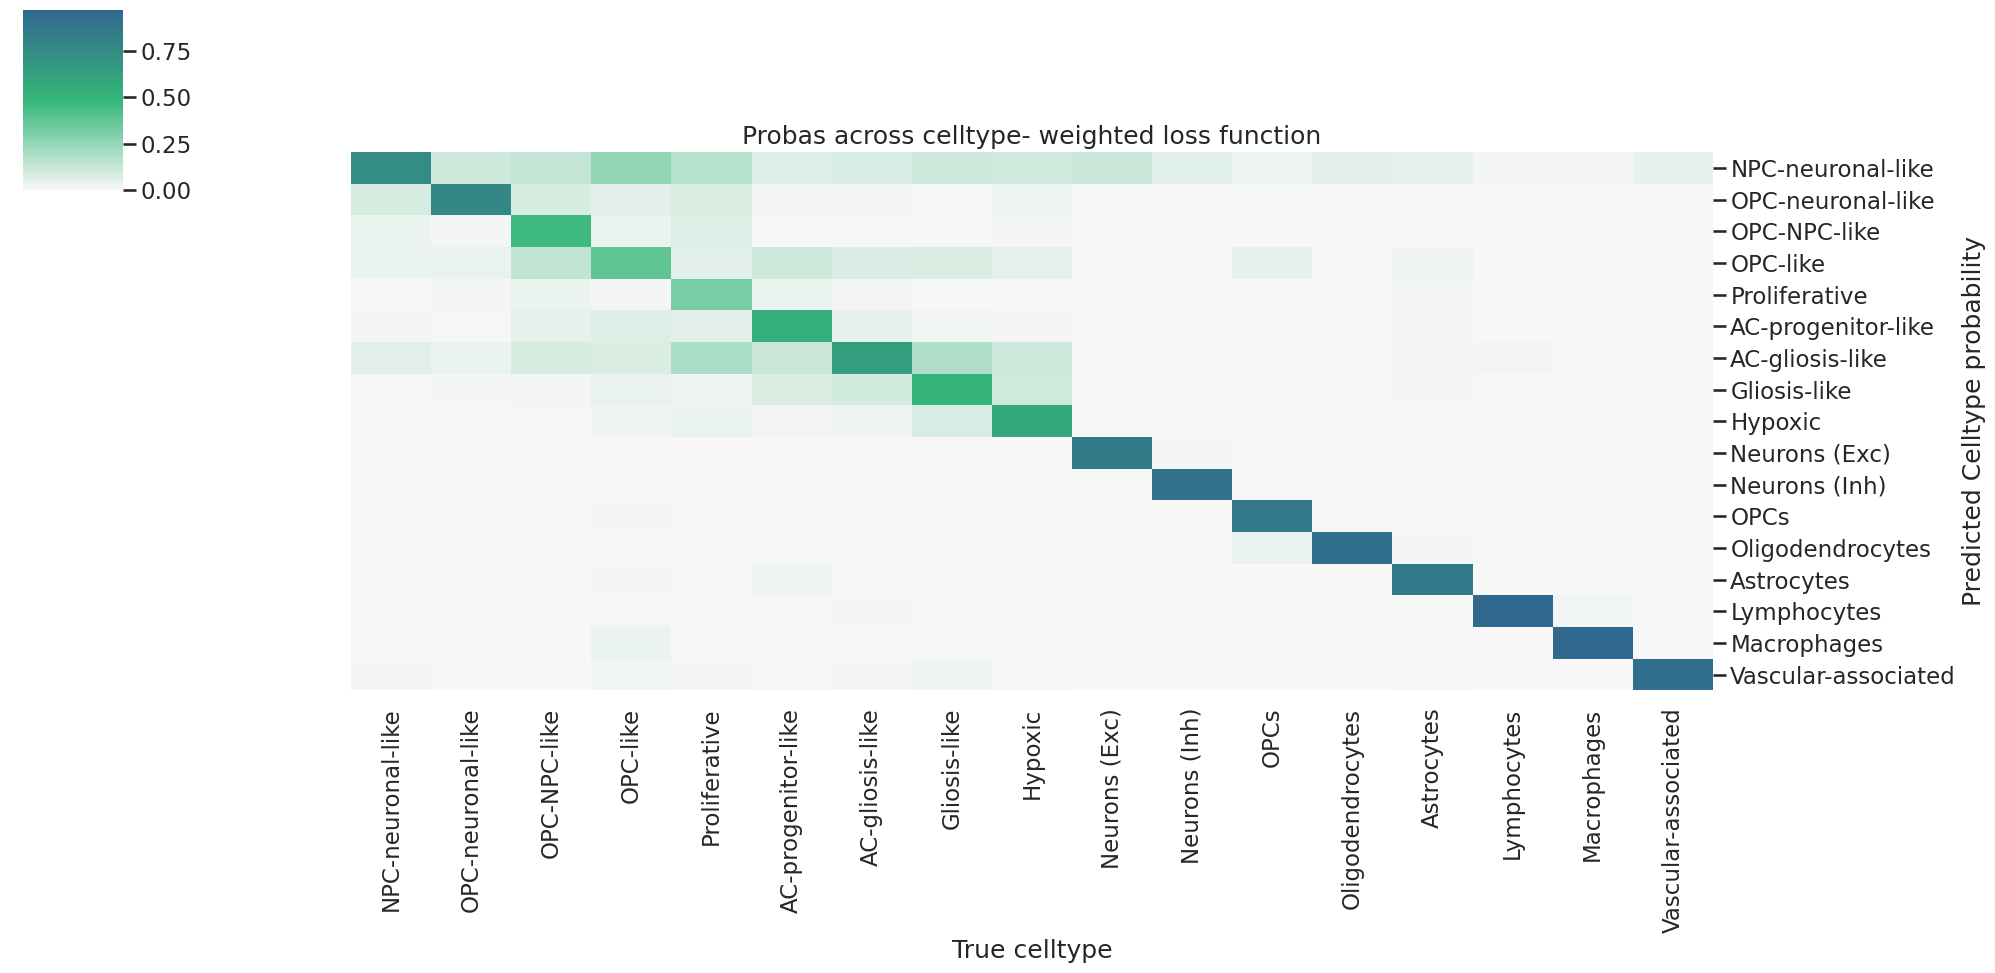

In [20]:
plot_order = ['Hypoxic','Gliosis-like','AC-gliosis-like', 'AC-progenitor-like', 'OPC-NPC-like', 'OPC-like','Proliferative','OPC-neuronal-like','NPC-neuronal-like','Astrocytes', 
       
       'Neurons (Exc)', 'Neurons (Inh)', 
        'OPCs', 'Oligodendrocytes', 
       'Vascular-associated', 'Lymphocytes', 'Macrophages']


plot_order = ['NPC-neuronal-like','OPC-neuronal-like','OPC-NPC-like', 'OPC-like','Proliferative', 'AC-progenitor-like','AC-gliosis-like', 'Gliosis-like', 'Hypoxic','Neurons (Exc)', 'Neurons (Inh)', 'OPCs', 'Oligodendrocytes','Astrocytes',
        'Lymphocytes', 'Macrophages','Vascular-associated']

from matplotlib.colors import LinearSegmentedColormap

# Custom colorblind-friendly colormap
colors = ["#f7f7f7", "#35b779", "#31688e"]   # Yellow (low), Teal (middle), Dark Blue (high)

# Create a colormap that emphasizes middle values
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

df_prob_atac = df_prob_atac.loc[plot_order][plot_order]
sns.set(context="talk")
clustermap = sns.clustermap(df_prob_atac.T, col_cluster=False,row_cluster=False,figsize=(20,10), cmap=cmap)
clustermap.ax_heatmap.set_ylabel('Predicted Celltype probability')
clustermap.ax_heatmap.set_xlabel('True celltype')
clustermap.ax_heatmap.set_title('Probas across celltype- weighted loss function')


In [21]:
cm_atac = cm / cm.sum(axis=1, keepdims=True)

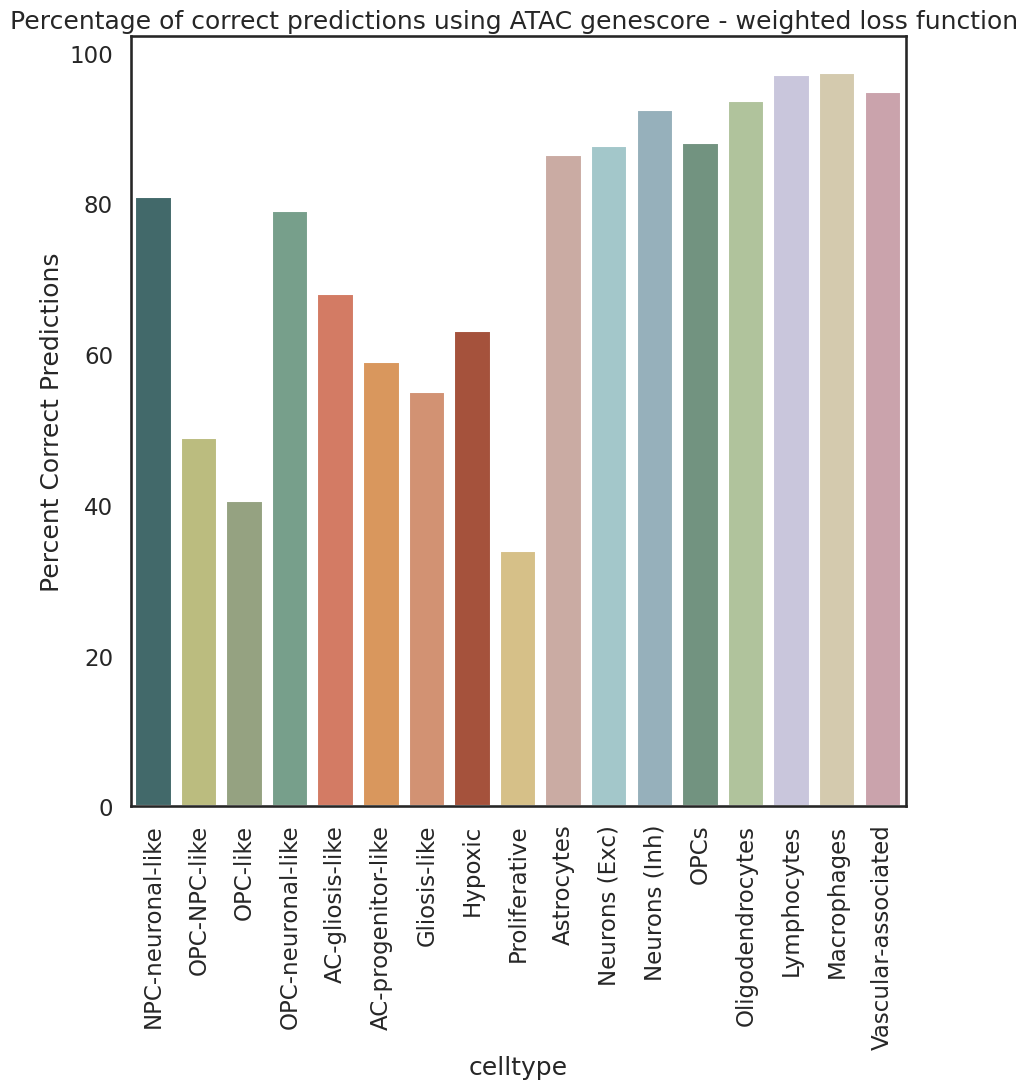

In [22]:
total_samples_per_class = cm.sum(axis=1)
correct_predictions = np.diag(cm)
percent_correct = (correct_predictions / total_samples_per_class) * 100
s = df_atac['CellType'].drop_duplicates()
s = pd.DataFrame(s)
s['celltype'] = [k.split('|')[1] for k in s.index.values]
s  =s.sort_values(by='CellType')
s['Percent Correct Predictions'] = percent_correct
s = s.drop(columns = 'CellType')

celltype_order= ['NPC-neuronal-like','OPC-NPC-like', 'OPC-like', 'OPC-neuronal-like','AC-gliosis-like', 'AC-progenitor-like','Gliosis-like', 'Hypoxic', 'Proliferative','Astrocytes','Neurons (Exc)', 'Neurons (Inh)', 'OPCs',
       'Oligodendrocytes', 'Lymphocytes', 'Macrophages','Vascular-associated']
sns.set(context="talk",style='white')
plt.figure(figsize=(10, 10))
ax = sns.barplot(data=s, x='celltype', y='Percent Correct Predictions', order=celltype_order, palette=cmap_celltype)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('Percentage of correct predictions using ATAC genescore - weighted loss function ') 

plt.show()

plt.close()

In [23]:
def calculate_entropy(matrix):
    # Normalize the rows to sum to 1
    row_sums = matrix.sum(axis=1, keepdims=True)
    normalized_matrix = matrix / row_sums
    
    # Replace zeros with a very small number to avoid log(0)
    normalized_matrix[normalized_matrix == 0] = np.finfo(float).eps
    
    # Calculate entropy for each row
    entropy = -np.sum(normalized_matrix * np.log(normalized_matrix), axis=1)
    return entropy



In [24]:

entropy = calculate_entropy(y_prob_atac) 

atac_genescore.obs['entropy'] = entropy
entropy_rna = calculate_entropy(y_prob_rna) 
rna.obs['entropy'] = entropy_rna

/omics/groups/OE0540/internal/users/msaraswat/hca_organoids/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


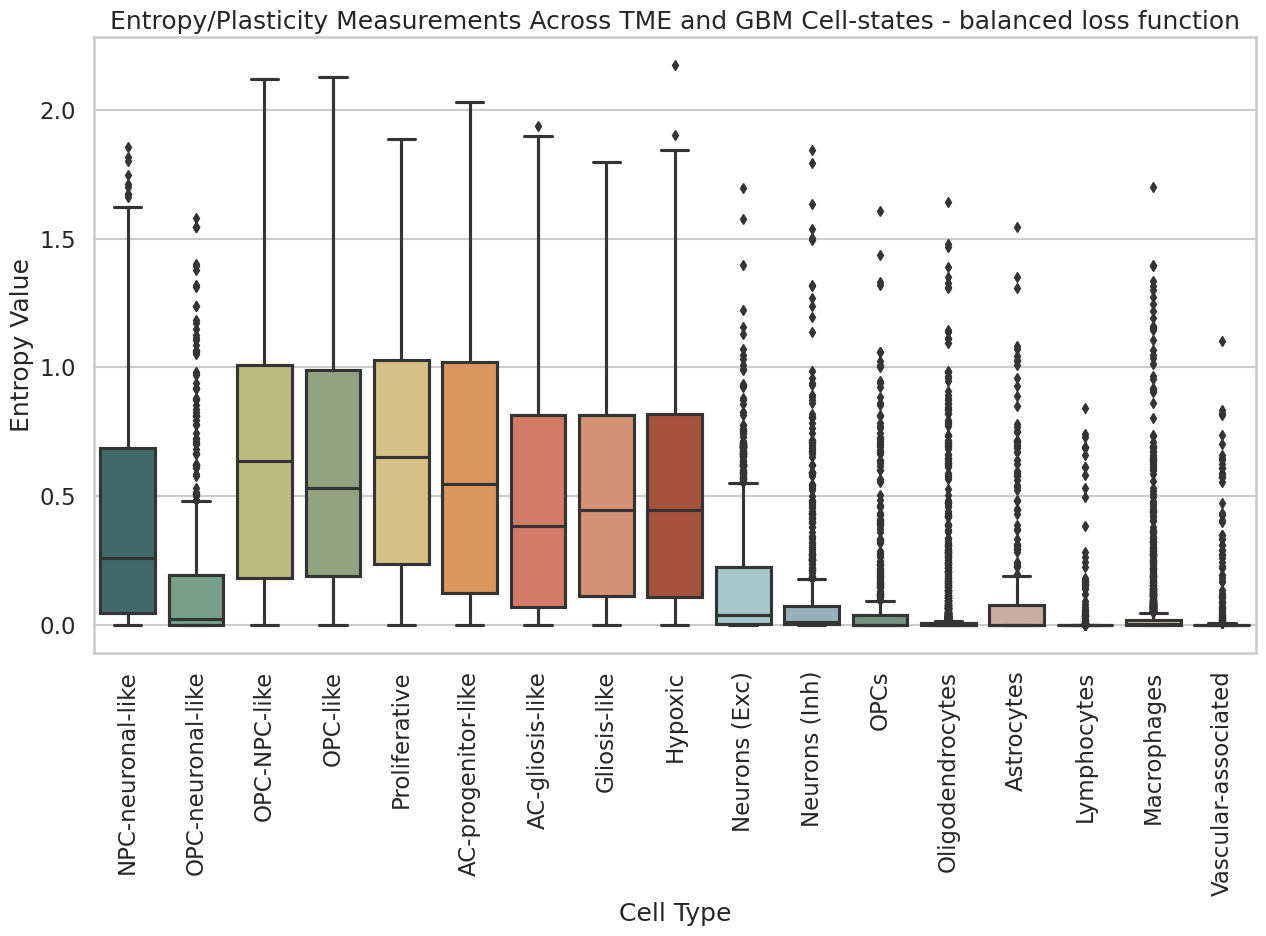

In [25]:


sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
cmap_celltype = {'NPC-neuronal-like': '#3B6F71',
'OPC-neuronal-like': '#70A68B',
'OPC-NPC-like':  '#C5C675',
'OPC-like': '#96A87B',
'Proliferative': '#E3C67B',
'AC-progenitor-like': '#EE9648',
'AC-gliosis-like': '#E57051',
'Gliosis-like': '#E28D63',
'Hypoxic': '#B7482A',
'Astrocytes': '#D0A79D',
'OPCs': '#6D997F',
'Oligodendrocytes': '#B0C996',
'Neurons (Exc)': '#9DCDD0',
'Neurons (Inh)': '#90B3C1',
'Macrophages': '#DBCDA7',
'Lymphocytes': '#C6C2E0',
'Vascular-associated': '#D09DA8',
'Undefined': '#DCDCDC',
'NA': '#C3C3C3'}

# Create the boxplot


celltype_order= ['NPC-neuronal-like','OPC-neuronal-like','OPC-NPC-like', 'OPC-like','Proliferative', 'AC-progenitor-like','AC-gliosis-like', 'Gliosis-like', 'Hypoxic','Neurons (Exc)', 'Neurons (Inh)', 'OPCs', 'Oligodendrocytes','Astrocytes',
        'Lymphocytes', 'Macrophages','Vascular-associated']

sns.boxplot(data = atac_genescore.obs, x='annotation', y='entropy', order=celltype_order, palette=cmap_celltype)

# Add some customization
plt.title('Entropy/Plasticity Measurements Across TME and GBM Cell-states - balanced loss function')
plt.xlabel('Cell Type')
plt.ylabel('Entropy Value')
plt.xticks(rotation=90)
# Display the plot
#plt.legend(title='Entropy/ Platicity ')

plt.show()




## grouped by donor

In [30]:
entropy_donor = atac_genescore.obs.groupby(['donor','annotation']).mean().reset_index()

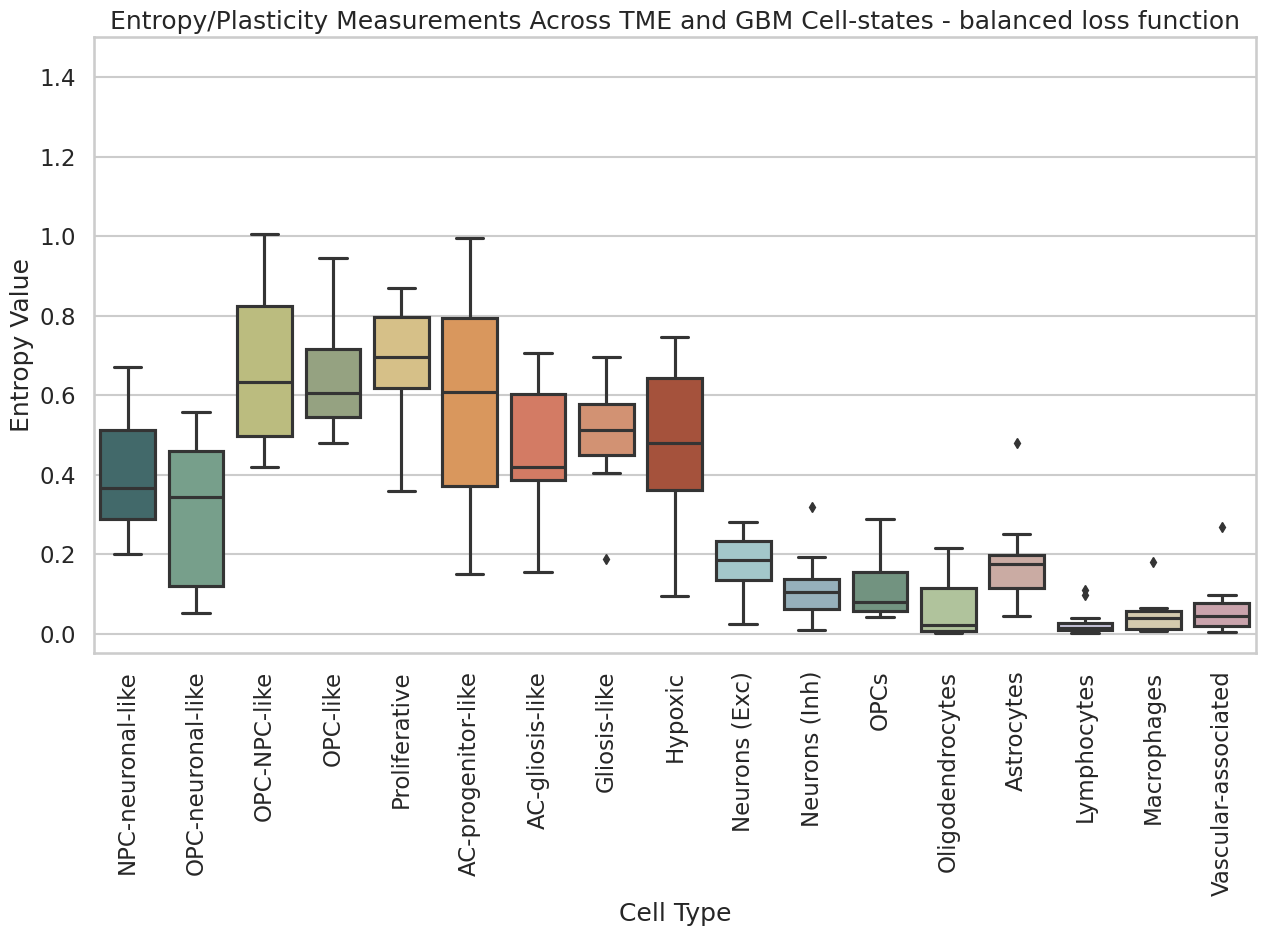

In [34]:


sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
cmap_celltype = {'NPC-neuronal-like': '#3B6F71',
'OPC-neuronal-like': '#70A68B',
'OPC-NPC-like':  '#C5C675',
'OPC-like': '#96A87B',
'Proliferative': '#E3C67B',
'AC-progenitor-like': '#EE9648',
'AC-gliosis-like': '#E57051',
'Gliosis-like': '#E28D63',
'Hypoxic': '#B7482A',
'Astrocytes': '#D0A79D',
'OPCs': '#6D997F',
'Oligodendrocytes': '#B0C996',
'Neurons (Exc)': '#9DCDD0',
'Neurons (Inh)': '#90B3C1',
'Macrophages': '#DBCDA7',
'Lymphocytes': '#C6C2E0',
'Vascular-associated': '#D09DA8',
'Undefined': '#DCDCDC',
'NA': '#C3C3C3'}

# Create the boxplot


celltype_order= ['NPC-neuronal-like','OPC-neuronal-like','OPC-NPC-like', 'OPC-like','Proliferative', 'AC-progenitor-like','AC-gliosis-like', 'Gliosis-like', 'Hypoxic','Neurons (Exc)', 'Neurons (Inh)', 'OPCs', 'Oligodendrocytes','Astrocytes',
        'Lymphocytes', 'Macrophages','Vascular-associated']

ax = sns.boxplot(data = entropy_donor, x='annotation', y='entropy', order=celltype_order, palette=cmap_celltype)

ax.set_ylim(top=1.5)
# Add some customization
plt.title('Entropy/Plasticity Measurements Across TME and GBM Cell-states - balanced loss function')
plt.xlabel('Cell Type')
plt.ylabel('Entropy Value')
plt.xticks(rotation=90)
# Display the plot
#plt.legend(title='Entropy/ Platicity ')

plt.show()


